# Implementación de los métodos




En este notebook se plantea la solución del problema utilizando los siguiente métodos: Newton, Broyden-Fletcher-Goldfarb-Shanno  (BFGS) y el gradiente descendente estocástico (SGD). El presente notebook es autocontenido, sin embargo, la implementación principal se realiza con un enfoque modular.

A continuación, se describe el conjunto de datos que se emplearán y se define el planteamiento del problema. Una explicación más detallada se realiza en el informe (en formato PDF) de este proyecto.

**Nota:** Esta implementación se basa en material y actividades impartidas por los profesores de los cursos de [Métodos Numéricos y optimización](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.3.Regresion_logistica_R.ipynb) (2010-I) (Prof. Erick Palacios Moreno) y Aprendizaje de Máquina (2019-II) (Prof. Rodrigo Mendoza Smith).


## Conjunto de datos

Por la restricciones de uso de la base de datos de entrenamiento original (además de una serie de requerimientos protocolares como contar con la aprobación de un Comité de Ética Independiente), optamos por trabajar con una de las dos bases de datos que los autores emplearon para validar sus modelos: KGH. La base de datos en mención, consta de $106$ casos positivos  de  pacientes  con  ébola  y  un  case fatality rate global por encima del setenta por ciento.  Originalmente,  previo  al tratamiento de los datos, la base tenía únicamente $44$ registros de triaje, $58$ registros de carga viral, con un total de 78 valores faltantes en todo el data set. Para  harmonizar  los  datos,  los  autores  transformaron  la  carga  viral  en  CT,  conforme  con  la curva estándar qPCR:

$$log_{(carga \; viral)} = m*CT + c_0$$

Nosotros, para fines del presente trabajo, empleamos una de las versiones imputadas de esta base de datos, dispuesta en el siguiente sitio: [ebola-imc-public](https://github.com/dapivei/ebola-imc-public/blob/master/data/kenema/test/pres-kgh/imputation-50.csv), misma que cuenta con $11$ variables: la variable output, $y_{i}$ asociada a la supervivencia o no del paciente ${i}$ con virus del ébola, y ${j}$ variables explicativas asociadas, $x_{i,j}$. Los regresores escogidos son aquellos que, conforme con nuestra principal referencia, son buenos predictores de la probabilidad de muerte o no de un paciente. 

|Tipo| Nombre|Descripción|
|---| --- | --- |
|Variable Numérica| CT |El cycle threshold (CT) es una variable que se calcula a partir de una relación médica bien conocida (qPCR) y la carga viral (una expresión númerica de la cantidad de virus dado un volúmen de fluido que normalmente se correlaciona con la severidad de una infección viral activa).|
|Variable Numérica|TEMP|Temperatura corporal del paciente. Toma valores de 1 a 73.|
|Variable Numérica|_AGE_ |Edad del paciente. Toma valores de $1$ a $73$.|
|Variable Categórica |_HEADCH_ | Presencia o no dolores de cabeza. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no dolores de cabeza.|
|Variable Categórica |  _BLEED_ | Presencia o no de sangrado. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no sangrado. |
|Variable Categórica |  _DIARR_ | Presencia o no de diarrea. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no diarrea.|
|Variable Categórica | _VOMIT_ | Dificultad para comer, conocido como disfagia, término técnico para describir el síntoma consistente en dificultad para la deglución (problemaspara  tragar).   Esta  dificultad  suele  ir  acompañada  de  dolores,  a  veces lancinantes (disfagia dolorosa u odinofagia .  Toma valores valores $1$ o $0$, dependiendo de si el paciente presenta o no de disfacia
|Variable Categórica | _PABD_ | Presencia o no de PADB.
|Variable Categórica |_WEAK_ | Presencia o no de debilidad o fatiga general.|
|Variable Categórica |_JAUN_ |Condición  en la cuál la piel, los ojos y los miembros mucosos que vuelven amarillos debido a altos niveles de bilirubina. Toma valores valores $0$ o $1$, dependiendo de si el paciente presenta o no ictericia.|
|Variable Categórica |_OUT_| Muerte o no muerte del paciente.  Toma valores $1$ o $0$.  Dependiendo desi el paciente muere o no muere.|




## Problema de regresión Logística

Matemáticamente, este conjunto se define de la siguiente manera: 

$$\mathcal{D}=\left\{ \left(x_{i},y_{i}\right)\in\mathbb{R}^{p}\times\left\{ 0,1\right\} :i\in\left[m\right]\right\} $$.

El método de _regresión logística_ asume que $Pr\left[y_{i}\mid x_{i},\beta\right]\sim Bernoulli\left(\mu_{i}\right)$
con los siguientes supuestos sobre la media, $\mu_{i}$:

$$
\mu_{i}=\sigma\left(\beta^{T}x_{i}\right) \label{eq-3.1} \tag{1}
$$
$$
\sigma(z)=\left(1+\exp\left(-z\right)\right)^{-1} \label{eq-3.2} \tag{2}
$$

donde $\beta\in\mathbb{R}^{p}$. 


Dado lo anterior, nuestro problema es encontrar un modelo tal que $\hat{\beta}\in\mathbb{R}^{p}$ explica de la mejor manera posible a $\mathcal{D}$. 

Para lograr lo anterior, debemos estimar el conjunto de parámetros $\hat{\beta}$ para modelar $Pr\left[y\mid x,\hat{\beta}\right]$ y predecir la etiqueta $\hat{y}\in\left\{ 0,1\right\} $ de un nuevo
dato $x$ por medio de:

$$
\hat{y}=\begin{cases}
1 & si\,\sigma\left(\hat{\beta}^{T}x\right)\geq0.5\\
0 & si\,\sigma\left(\hat{\beta}^{T}x\right)<0.5
\end{cases}\label{eq-3.3} \tag{3}
$$

la función de pérdida que queremos minimizar en este problema corresponde a la _log-verosimilitud negativa_ , que está dada por:

$$
F(\beta):=LVN(\beta)=-\sum_{i=1}^{m}\left[y_{i}log\mu_{i}+(1-y_{i})log(1-\mu_{i})\right]\label{eq-3.4} \tag{4}
$$


Una vez planteado lo anterior, queremos encontrar $\hat{\beta}$ por medio de métodos numéricos de optimización de tal forma que se minimize ([4](#mjx-eqn-eq1)) para el conjunto de datos dado.


_En los siguientes fragmentos de código se realiza el planteamiento del problema, desde la importación de datos hasta el proceso de entrenamiento del modelo utilizando distintos algoritmos de optimización que se explican con brevedad._



---------------------

## Importación y exploración del conjunto de datos

En esta sección se importa y transforma los datos, con el fin de obtener el conjunto $\mathcal{D}$.

In [4]:
# librerías
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import sys
import matplotlib.pyplot as plt

In [5]:
url="https://raw.githubusercontent.com/afcarl/ebola-imc-public/master/data/kenema/test/pres-kgh/imputation-50.csv"
df_raw=pd.read_csv(url,sep=",")

In [6]:
df_raw.head()
# df[df.isnull().any(axis=1)] - no hay NAs

,OUT,CT,AGE,TEMP,HEADCH,BLEED,DIARR,JAUN,VOMIT,PABD,WEAK
0,1,28.652450,42.0,36.3,0,0,1,0,0,1,1
1,1,25.736016,45.0,36.5,1,0,1,0,0,1,1
2,1,20.747653,65.0,38.0,1,0,0,0,0,0,0
3,1,22.736993,44.0,38.6,1,0,0,0,0,0,1
4,1,20.846284,11.0,38.4,1,0,0,0,1,0,1


In [7]:
# verificar tipo de variables 
df_raw.dtypes

OUT         int64
CT        float64
AGE       float64
TEMP      float64
HEADCH      int64
BLEED       int64
DIARR       int64
JAUN        int64
VOMIT       int64
PABD        int64
WEAK        int64
dtype: object

In [8]:
# Resumen de las variables
df_raw.describe()

,OUT,CT,AGE,TEMP,HEADCH,BLEED,DIARR,JAUN,VOMIT,PABD,WEAK
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0,106.000000,106.000000,106.000000
mean,0.764151,25.720411,34.102170,37.256604,0.603774,0.066038,0.405660,0.0,0.207547,0.273585,0.500000
std,0.426545,5.869164,17.382844,1.030767,0.491436,0.249528,0.493352,0.0,0.407477,0.447916,0.502375
min,0.000000,12.100000,0.830000,36.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.000000,22.149857,22.000000,36.300000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,25.236301,35.500000,37.250000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000
75%,1.000000,28.680924,45.000000,38.225000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
max,1.000000,39.799999,80.000000,39.900000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [9]:
df_raw_cat = df_raw.copy()

cat_vars = ['OUT', 'HEADCH', 'BLEED', 'DIARR', 'JAUN', 'VOMIT',
       'PABD', 'WEAK']
for var in cat_vars:
    df_raw_cat[var] = df_raw_cat[var].astype('category')
df_raw_cat.dtypes


OUT       category
CT         float64
AGE        float64
TEMP       float64
HEADCH    category
BLEED     category
DIARR     category
JAUN      category
VOMIT     category
PABD      category
WEAK      category
dtype: object

In [10]:
df_raw_cat.describe()

,CT,AGE,TEMP
count,106.000000,106.000000,106.000000
mean,25.720411,34.102170,37.256604
std,5.869164,17.382844,1.030767
min,12.100000,0.830000,36.000000
25%,22.149857,22.000000,36.300000
50%,25.236301,35.500000,37.250000
75%,28.680924,45.000000,38.225000
max,39.799999,80.000000,39.900000


In [11]:
# Describe categorical data
df_proc_cat = df_raw_cat.select_dtypes(include=['category']).copy()
df_proc_cat.describe()

,OUT,HEADCH,BLEED,DIARR,JAUN,VOMIT,PABD,WEAK
count,106,106,106,106,106,106,106,106
unique,2,2,2,2,1,2,2,2
top,1,1,0,0,0,0,0,1
freq,81,64,99,63,106,84,77,53


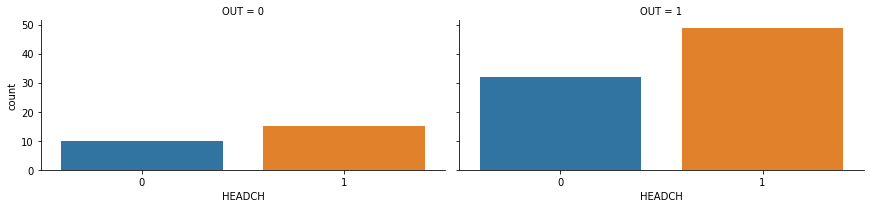

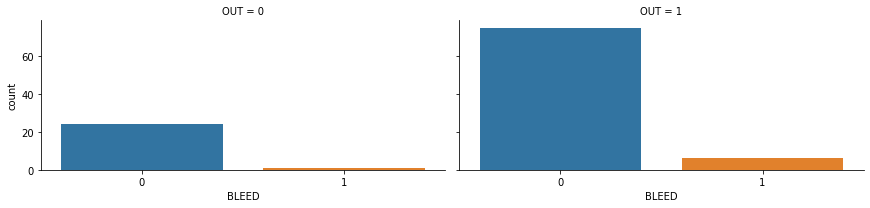

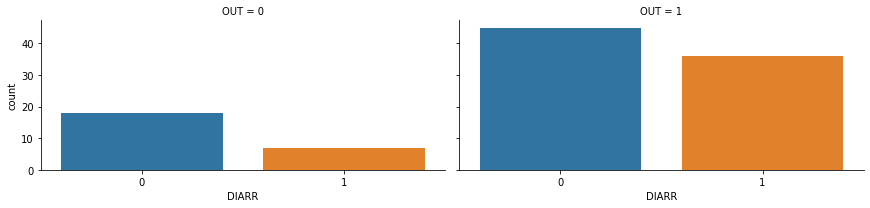

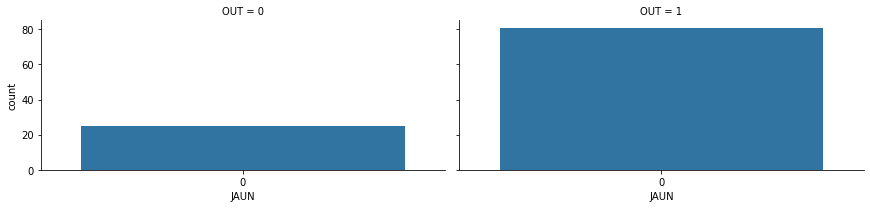

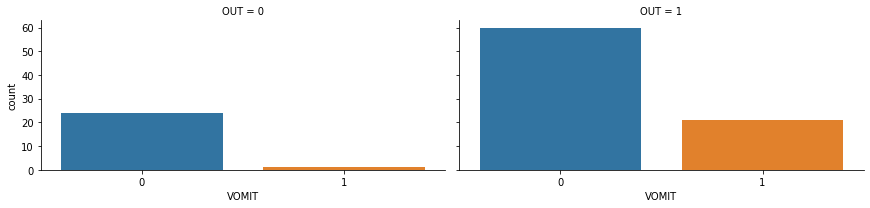

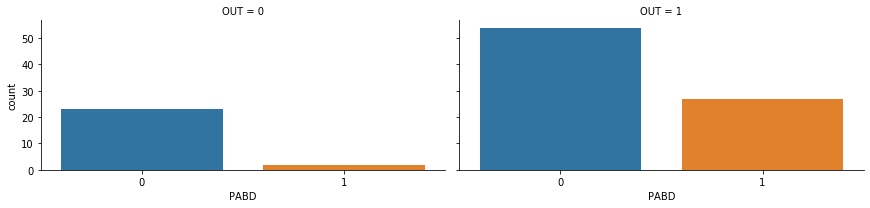

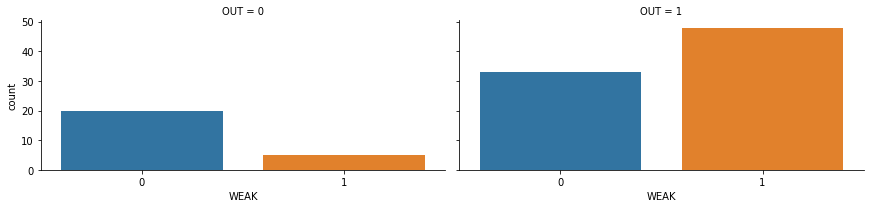

In [12]:
cat_vars = cat_vars[1:]

for i, col_val in enumerate(cat_vars):
    sns.catplot(x = col_val, y = None, hue= None, col="OUT",
                data=df_proc_cat, kind="count",
                height=3, aspect=2);


**Algunas observaciones sobre los datos**

- El case fatality rate (OUT) de nuestra base de datos se sitúa en 76 por ciento. Es decir, del total de pacientes con ébola, 81 murieron.

- Para este conjunto de datos la variable `JAUN` no tiene variabilidad, por lo tanto no es una variable, y se omite.


Dado lo anterior, se ajusta el set de datos:

- Se crean 3 grupos de edades, utilizando el percetil 25 (22 años), percentil 50 (36 años) y percentil 75 (45 años).

- Se elimina la columna `JAUN`.

## Transformaciones al conjunto de datos

In [13]:
# ajustes en df_raw 
df_proc = df_raw
df_proc['INTER_AGE'] = "NA"

df_proc.dtypes

OUT            int64
CT           float64
AGE          float64
TEMP         float64
HEADCH         int64
BLEED          int64
DIARR          int64
JAUN           int64
VOMIT          int64
PABD           int64
WEAK           int64
INTER_AGE     object
dtype: object

In [14]:
# ajustes en df_raw 
df_proc = df_raw

# para la variable edad se crean cuatro categorías
age_p25 = math.ceil(df_proc['AGE'].quantile(.25))
age_p50 = math.ceil(df_proc['AGE'].quantile(.50))
age_p75 = math.ceil(df_proc['AGE'].quantile(.75))

df_proc['INTER_AGE'] = "NA"
df_proc.loc[(df_proc['AGE'] <= age_p25), 'INTER_AGE'] = 1
df_proc.loc[(df_proc['AGE'] > age_p25) & (df_proc['AGE'] <= age_p50), 'INTER_AGE'] = 2
df_proc.loc[(df_proc['AGE'] > age_p50) & (df_proc['AGE'] <= age_p75), 'INTER_AGE'] = 3
df_proc.loc[(df_proc['AGE'] > age_p75), 'INTER_AGE'] = 4

## one hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df_proc[['INTER_AGE']]).toarray())
enc_df = enc_df.rename(columns={0: f"hasta{age_p25}", 1: f"entre{age_p25+1}y{age_p50}", 2: f"entre{age_p50+1}y{age_p75}", 3:f"mayor{age_p75}"})
# merge with main df bridge_df on key values
df_proc = df_proc.join(enc_df)

# se asignan como categoricas a las binarias, incluido el output
#bin_vars = ['OUT', 'HEADCH', 'BLEED', 'DIARR', 'JAUN', 'VOMIT',
#       'PABD', 'WEAK', 'INTER_AGE', f"hasta{age_p25}", f"entre{age_p25+1}y{age_p50}", f"entre{age_p50+1}y{age_p75}", f"mayor{age_p75}"]

#esta asignacion hace que genera problemas al evaluar el sigmoide
#for var in bin_vars:
#    df_proc[var] = df_proc[var].astype('category')
    
# se omiten las variables JAUN, AGE, INTER_AGE
del_vars = ["JAUN", "AGE", "INTER_AGE"]
for var in del_vars:
    df_proc = df_proc.drop(var, axis=1)    
    
# se comprueban los tipos de variable
df_proc.dtypes

OUT             int64
CT            float64
TEMP          float64
HEADCH          int64
BLEED           int64
DIARR           int64
VOMIT           int64
PABD            int64
WEAK            int64
hasta22       float64
entre23y36    float64
entre37y45    float64
mayor45       float64
dtype: object

In [15]:
df_proc

,OUT,CT,TEMP,HEADCH,BLEED,DIARR,VOMIT,PABD,WEAK,hasta22,entre23y36,entre37y45,mayor45
0,1,28.652450,36.3,0,0,1,0,1,1,0.0,0.0,1.0,0.0
1,1,25.736016,36.5,1,0,1,0,1,1,0.0,0.0,1.0,0.0
2,1,20.747653,38.0,1,0,0,0,0,0,0.0,0.0,0.0,1.0
3,1,22.736993,38.6,1,0,0,0,0,1,0.0,0.0,1.0,0.0
4,1,20.846284,38.4,1,0,0,1,0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1,24.191797,36.4,0,0,1,1,1,1,0.0,0.0,1.0,0.0
102,1,20.846284,38.4,0,0,0,1,0,1,0.0,1.0,0.0,0.0
103,0,38.816561,36.0,0,0,0,0,0,0,1.0,0.0,0.0,0.0
104,1,21.960294,36.4,0,0,0,0,0,0,0.0,1.0,0.0,0.0


## Planteamiento del problema de regresión

A continuación se plantea el código que computa las ecuaciones ([1](#mjx-eqn-eq1)), ([2](#mjx-eqn-eq1)) y ([4](#mjx-eqn-eq1)), planteadas inicialmente.

In [16]:
def sigmoide(z):
    '''
    
    Función que devuelve el sigmoide de un vector
    
        - Parámetros:
        
            -- z (vec): vector numérico de m entradas
        
        - Salidas
        
            -- sig (vec): vector númerico de m entradas, cada entrada tiene 
        
                         un valor entre -1 y 1
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    if type(z) is not np.ndarray:
        sys.exit('Error: la entrada debe ser de tipo numpy.ndarray')
        
    sig = 1/(1+ np.exp(-z))
    
    return sig
    
def calc_mu(X,beta):
    '''
    
    Función que calcula la media para una variable aleatoria con distribución bernoulli.
    
        - Parámetros:
        
            -- X (mat): matriz de mxp entradas
            
            -- beta (vec): vector con p entradas
            
        - Salidas
        
            -- mu (vec): vector de m entradas
    '''
    a = np.matmul(beta,np.transpose(X))
    mu = sigmoide(a)

    return mu
    
def f(X,y,beta):
    '''
    
    Función que computa la log-verosimilitud negativa
    
        - Parámetros:
    
            -- X (mat): matriz de mxp entradas

            -- y (vec): vector de de m entradas de la variable output

            -- beta (vec): vector de p entradas

        - Salidas
    
            -- lvn (int): log-verosimilitud negativa
    '''
    
    
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')
    if beta.shape[0]!= p:
        sys.exit('Error:  El número de columnas de X debe ser igual al número de entradas del vector beta.')

    prob = calc_mu(X,beta)
    # Log-verosimilitud negativa 
    lvn = -sum(y*np.log(prob)+(1-y)*(np.log(1-prob)))
    return lvn

Reescribiendo la ecuación de la función de pérdida ([4](#mjx-eqn-eq1)), tenemos:

$$F(\beta)=- \sum_{i=1}^{m}[y_i log\mu_i + (1-y_i)log(1-\mu_i)]$$

Las expresiones correspondientes al gradiente y a la matriz hessiana asociados a este problema, se plantean a continuación:

\begin{align}
\nabla F(\beta) & =\frac{d}{d\beta}F(\beta)\nonumber \\
 & =\sum_{i}\left(\mu_{i}-y_{i}\right)x_{i}\nonumber \\
 & =\boldsymbol{X}^{T}\left(\boldsymbol{\mu}-\boldsymbol{y}\right)\label{eq:gradient}
\end{align}

Por otro lado, la ecuación que describe la matrix Hessiana es la siguiente:

\begin{align}
\nabla^{2}F(\beta) & =\frac{d}{d\beta}\nabla F\left(\beta\right)^{T}\nonumber \\
 & =\sum_{i}\left(\nabla_{\beta}\mu_{i}\right)x_{i}^{T}\nonumber \\
 & =\sum_{i}\mu_{i}\left(1-\mu_{i}\right)x_{i}x_{i}^{T}\nonumber \\
 & =\boldsymbol{X^{T}SX}\label{eq:hessian}
\end{align}

donde $\boldsymbol{S}\triangleq diag\left(\mu_{i}\left(1-\mu_{i}\right)\right)$.
Como es resaltado por Murphy (2012), es definida positiva, lo que implica que ([4](#mjx-eqn-eq1)) es convexa
y tiene un mínimo global.

In [17]:
def gradiente_f(X,y,beta):
    '''
    
    Función que calcula el gradiente asociado la log-verosimilitud negativa del 
    
    problema de regresión logística
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas
            
            - y (vec): vector de de m entradas de la variable output
            
            - beta (vec): vector de p entradas
        
        ** Salidas
        
            - grad (vec): vector de m entradas
    '''
        
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')
    if beta.shape[0]!= p:
        sys.exit('Error:  El número de columnas de X debe ser igual al número de entradas del vector beta.')

    mu = calc_mu(X,beta)    
    grad = np.matmul(np.transpose(X), mu-y)    
    return grad


def hessiana_f(X,y,beta):
    '''
    
    Función que calcula la matriz Hessiana asociada a la log-verosimilitud negativa del 
    
    problema de regresión logística
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas
            
            - y (vec): vector de de m entradas de la variable output
            
            - beta (vec): vector de p entradas
        
        ** Salidas
        
            - hes (vec): vector de m entradas
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')
    if beta.shape[0]!= p:
        sys.exit('Error:  El número de columnas de X debe ser igual al número de entradas del vector beta.')

    mu = calc_mu(X,beta)
    S = np.diag(mu*(1-mu))
    hes = np.matmul(np.transpose(X),np.matmul(S,X))
    return hes

In [18]:
def normalize(x):
    '''
    
    Función que normaliza un vector
    
        ** Parametros:
    
            - x: vector a normalizar
    
        ** Salidas:
    
            - norm : vector x normalizado
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    if type(x) is not np.ndarray:
        sys.exit('Error: la entrada debe ser de tipo numpy.ndarray')
         
    norm = x/np.sqrt(sum(x*x))
    return norm

In [19]:
def clasifica(X, beta_hat,limit=0.5):
    '''
    
    Función que clasifica la ocurrencia de probabilidades en dos grupos.
    
    Emplea el parámetro límite para delimitar si se clasifica en el grupo 0 o 1.
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas
            
            - beta_hat (array): optimized parameter
            
            - limit (float64): 0<limit<1: Threshold for each classification
            
        
        ** Salidas:
        
            - yhat: array of classifed data
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    if type(X) is not np.ndarray or type (beta_hat) is not np.ndarray:
        sys.exit('Error: X y beta_hat deben ser de tipo numpy.ndarray')
    if limit > 1 or limit < 0:
        sys.exit('Error:  limit es un paramétro que debe estar entre 0 y 1')       
    
    mu = calc_mu(X,beta_hat)
    yhat = mu
    yhat[mu<limit] = 0
    yhat[mu>=limit] = 1
    return yhat

In [20]:
def descent_direction(X, y, beta, method="max",H=None):
    '''
    
    Función que devuelve vector normalizado (px1) que apunta en la direccion de decenso
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas

            - y (vec): vector de de m entradas de la variable output

            - beta (vec float64): vector de entradas a optimizar

            - method (str): método que determina la dirección de descenso
    
                    --Opciones:
    
                            --- max: método de descenso
                            
                            --- newton: método de Newton
                            
                            --- bfsg: metodo bfsg
                            
            - H (mat pxp): Parámetro para la dirección de decenso del metodo bfgs
    
        ** Salidas
    
            - pk (vec): vector normalizado con la direccion del paso
    '''
    if(method == "max"):
        pk = gradiente_f(X,y,beta)
    
    elif(method == "newton"):
        grad = gradiente_f(X,y,beta)
        hess = hessiana_f(X,y,beta)
        pk = np.linalg.solve(hess,grad)
        
    elif(method=="bfsg"):
        # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
        if type(H) is not np.ndarray:
            sys.exit('Error: H debe ser de tipo numpy.ndarray')
        pk = np.matmul(H,gradiente_f(X,y,beta))
                              
    return - normalize(pk)


In [21]:
def calc_H(X,y,beta,beta_new=None,H=None):
    '''
    
    Función que actualiza los valores de la matriz H del metodo bfgs para cada iteracion
    
        ** Parametros:
        
            - X (mat): matriz de mxp entradas

            - y (vec): vector de de m entradas de la variable output
        
            - beta (array) - valor de cantidad a optimizar en la iteracion actual
            
            - beta_new (array)- valore de la cantidad a optimizar despues de la actualizacion
            
            - H (mat)- valor de la matriz H en la iteracion anterior
        
        
        
        ** Salidas:
        
            - H (mat): valor de la matriz para la siguiente iteracion       
    '''
    
    w = gradiente_f(X,y,beta_new)- gradiente_f(X,y,beta)
    z = beta_new-beta
    Hz = np.matmul(H,z)
    dotwz = np.dot(w,z)
    dotzhz = np.dot(Hz,z)
    H = H+(np.outer(w,w)/dotwz)-(np.outer(Hz,Hz)/dotzhz)
   
    return H

In [22]:
def calc_lr(X, y, beta, lr, pk, c1=10**(-4), tao=0.5, reset_lr=False):
    '''
    
    Función que calcula el tamaño del paso para cada iteración utilizando la condicion de armijo.
    
    La tasa de aprendizaje minima es la que tenia en el paso anterior.
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas
            
            - y (vec): vector de de m entradas de la variable output
            
            - lr (float64): tasa de aprendizaje
            
            - pk (array px1 float64): direccion de decenso
            
            - c1 (float64) 0<c1<1: parametro de control
            
            - tao (float64) 0<tao<1: parametro de decrecimiento de lr
            
        ** Salidas
        
            - lr (float64): tamaño de paso
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad    
    if tao > 1 or tao < 0:
        sys.exit('Error:  tao es un parámetro que debe estar entre 0 y 1')  
    if c1 > 1 or c1 < 0:
        sys.exit('Error:  c1 es un paramétro que debe estar entre 0 y 1') 

    # Inicializamos 
    tao = 0.9
    max_iter = 100
    iter = 0
    
    # Inicializa lr
    if reset_lr==True: lr = 1

    # Evaluaciones periódicas
    grad = gradiente_f(X,y,beta)
    eval_f = f(X,y, beta)
    
    # Primera iteracion
    f_x =  f(X,y, beta + lr*pk) #en nocedal es phi(alpha)
    f_x1 = eval_f + c1 * lr *  np.dot(grad,pk) # en nocedal es l(alhpa)
    
    while ((f_x > f_x1) & (iter < max_iter)):
        lr = lr*tao
        f_x =  f(X,y, beta + lr*pk) 
        f_x1 = eval_f + c1 * lr *  np.dot(grad,pk) 
        iter+=1
    
    return lr

In [23]:
# prueba
# prueba
# No esta funcionando bien
# Longitud de paso con condiciones completas de wolf

def calc_lr_wolf(X, y, beta, lr, pk, c1=10**(-4), c2=0.9, tao=0.5, reset_lr=False):
    '''
    
    Función que calcula el tamaño del paso para cada iteración utilizando la condicion de armijo.
    
    La tasa de aprendizaje minima es la que tenía en el paso anterior.
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas
            
            - y (vec): vector de de m entradas de la variable output
            
            - lr (float64): tasa de aprendizaje
            
            - pk (array px1 float64): direccion de decenso
            
            - c1 (float64) 0<c1<1: parametro de control
            
            - tao (float64) 0<tao<1: parametro de decrecimiento de lr
        
        
        
        ** Salidas
        
            - lr (float64): tamaño de paso
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    if tao > 1 or tao < 0:
        sys.exit('Error:  tao es un parámetro que debe estar entre 0 y 1')  
    if c1 > 1 or c1 < 0:
        sys.exit('Error:  c1 es un paramétro que debe estar entre 0 y 1') 
    #if pk >= 0 :
    #    sys.exit('Error: pk debe ser negativo')
        
    # Inicializamos 
    tao = 0.5
    max_iter = 50
    iter = 0
    
    # Inicializa lr
    if reset_lr==True: lr=1

    # Evalauciones periodicas
    grad = gradiente_f(X,y,beta)
    eval_f = f(X,y, beta)
    
    # Primera iteracion
    f_x =  f(X,y, beta + lr*pk) #en nocedal es phi(alpha)
    f_x1 = eval_f + c1 * lr *  np.dot(grad,pk) # en nocedal es l(alhpa)
    
    gf_x = np.dot(gradiente_f(X,y, beta+lr*pk) , pk)
    gf_x1 = c2* np.dot(grad, pk)
    
    while ((f_x>f_x1) & (gf_x<gf_x1) & (iter<max_iter)):
        lr =lr*tao
        f_x =  f(X,y, beta + lr*pk) 
        f_x1 = eval_f + c1 * lr *  np.dot(grad,pk) 
        
        gf_x = np.dot(gradiente_f(X,y, beta+lr*pk) , pk)
        #gf_x1 = c2* np.dot(grad, pk)
    
        
        iter+=1
    
    return lr

In [24]:
def gradient_descent(X, y, lr=1, tol=10**(-7), max_iter=10**5, method="max", reset_lr=False, verbose_n=1000):
    '''
    
    Función que devuelve vector de parámetros beta (px1) resultante del proceso
    
    de optimización por descenso de gradiente
    
        ** Parámetros:
        
            - X (mat): matriz de mxp entradas
            
            - y (vec): vector de de m entradas de la variable output
            
            - lr (float64): valor inicial de la tasa de aprendizaje
            
            - tol (float64): criterio de convergencia
            
            - max_iter (int): número máximo de iteraciones
            
            - method (str): método que determina la dirección de descenso
            
                Opciones:
                
                    -- max: método de descenso
                    
                    -- newton: método de Newton
                    
                    -- bfsg
        
        ** Salidas
        
            - beta_new (vec): vector de p entradas con parámetros que minimizan la función de pérdida
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')

    
    # Inicializa
    iteraciones=0
    H = None
    dims = X.shape[1]
    tol = tol*dims
    
    # Inicializamos beta aleatoria
    beta = np.random.normal(1,3,dims)
    if method =="bfsg": H = np.identity(dims)
    
    # Primera iteracion
    pk =  descent_direction(X, y, beta, method,H)
    beta_new = beta + lr*pk
    if method == "bfsg": H=calc_H(X,y,beta,beta_new,H) 
    
    # Condición de paro.
    while ((np.linalg.norm(gradiente_f(X,y,beta_new)) > tol) & (iteraciones < max_iter)):
        iteraciones+=1 #contador de ciclo
        
        beta = beta_new
        pk =  descent_direction(X,y,beta,method,H)
        lr = calc_lr(X, y, beta, lr, pk, reset_lr = reset_lr)
        
        beta_new = beta + lr*pk
        
        if method == "bfsg": H=calc_H(X,y,beta,beta_new,H)
            
        # Imprime

        if iteraciones % verbose_n == 0:
            print("************************************************************************")
            grad=np.linalg.norm(gradiente_f(X,y,beta_new))
            print(f'GRADIENTE: {grad:.7E}, LEARNING RATE: {lr:.4E}, Nº ITERACIONES: {iteraciones}')
            

    print("*========================================================================*")    
    if iteraciones == max_iter:print("Alcanzó el número máximo de iteraciones")

    print("ITERACIONES: ",iteraciones)
    print("GRADIENTE DE F: ",np.linalg.norm(gradiente_f(X,y,beta_new)))
    print("*========================================================================*")
    
    return beta_new

## Split and Train

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data =df_proc.to_numpy()
y = data[:,0]
X = data[:,1:]
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=.2)

# Scale data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [26]:

%%time 

beta_hat = gradient_descent(x_train,y_train,max_iter=10**6,reset_lr=False,verbose_n=100000)
yhat = clasifica(x_test,beta_hat)

print("BETA_HAT: ", beta_hat)
print("ERROR DE CLASIFICACIÓN: ",round(100*sum(abs(y_test-yhat))/len(yhat),2),"%")
print("*========================================================================*")


************************************************************************
GRADIENTE: 1.8444854E-03, LEARNING RATE: 7.7355E-04, Nº ITERACIONES: 100000
************************************************************************
GRADIENTE: 5.2093201E-04, LEARNING RATE: 2.1847E-04, Nº ITERACIONES: 200000
************************************************************************
GRADIENTE: 5.2093029E-04, LEARNING RATE: 2.1847E-04, Nº ITERACIONES: 300000
************************************************************************
GRADIENTE: 5.2092943E-04, LEARNING RATE: 2.1847E-04, Nº ITERACIONES: 400000
************************************************************************
GRADIENTE: 5.2092891E-04, LEARNING RATE: 2.1847E-04, Nº ITERACIONES: 500000
************************************************************************
GRADIENTE: 5.2092857E-04, LEARNING RATE: 2.1847E-04, Nº ITERACIONES: 600000
************************************************************************
GRADIENTE: 1.4712555E-04, LEARNIN

In [27]:
%%time
# Método de Newton
beta_hat = gradient_descent(x_train,y_train, method="newton",max_iter = 10**5,verbose_n = 10)
yhat = clasifica(x_test,beta_hat)

print("BETA_HAT: ", beta_hat)
print("ERROR DE CLASIFICACIÓN: ",round(100*sum(abs(y_test-yhat))/len(yhat),2),"%")
print("*========================================================================*")

************************************************************************
GRADIENTE: 5.9664923E+00, LEARNING RATE: 1.0000E+00, Nº ITERACIONES: 10
************************************************************************
GRADIENTE: 4.9669549E-01, LEARNING RATE: 1.0000E+00, Nº ITERACIONES: 20
************************************************************************
GRADIENTE: 1.3981306E-03, LEARNING RATE: 1.0000E+00, Nº ITERACIONES: 30
************************************************************************
GRADIENTE: 1.1753876E-06, LEARNING RATE: 1.0000E+00, Nº ITERACIONES: 40
*========================================================================*
ITERACIONES:  40
GRADIENTE DE F:  1.1753875969730942e-06
*========================================================================*
BETA_HAT:  [-9.7063437  15.34064205 -5.80107833 13.3216858   1.64484345 18.090213
  0.53395169  3.89002152  2.84740552  4.61236333  5.03987498  4.96963699]
ERROR DE CLASIFICACIÓN:  18.18 %
*=======================

In [25]:
%%time
# Método BFSG

beta_hat = gradient_descent(x_train,y_train, method = "bfsg",max_iter = 10**6,lr=1,verbose_n = 100000)
yhat = clasifica(x_test,beta_hat)

print("BETA_HAT: ", beta_hat)
print("ERROR DE CLASIFICACIÓN: ",round(100*sum(abs(y_test-yhat))/len(yhat),2),"%")
print("*========================================================================*")

/Users/danielapintoveizaga/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/Users/danielapintoveizaga/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply


************************************************************************
GRADIENTE: 6.7604013E-04, LEARNING RATE: 1.8530E-01, Nº ITERACIONES: 100000
************************************************************************
GRADIENTE: 1.8246751E-06, LEARNING RATE: 1.8530E-01, Nº ITERACIONES: 200000
*========================================================================*
ITERACIONES:  207214
GRADIENTE DE F:  1.1997522410752398e-06
*========================================================================*
BETA_HAT:  [-1.92597509e+02  5.62066406e+02 -7.16006035e+01 -9.05363951e-02
  2.33935569e+01  1.11631145e+02 -5.46857075e+01  8.48952910e+01
  2.35974039e+01  2.56294180e+01  6.29470910e+01  6.70883012e+01]
ERROR DE CLASIFICACIÓN:  13.64 %
*========================================================================*
CPU times: user 38.1 s, sys: 225 ms, total: 38.3 s
Wall time: 38.2 s


## Descenso del gradiente estocastico

Calculamos la función de riesgo empírico como la esperanza de la funcion de perdida evaluada sobre todos los puntos del dominio.

$$L_{emp}=\frac{1}{m} \sum^{m}_{i=1} y_i log(\mu_i) + (1-y_i) log(1-\mu_i)$$  
<br>
$$ \mu_i = (1+e^{-\beta^T x_i})^{-1}= \sigma(\beta^T x_i)$$

Y el gradiente de la función de riesgo esta dado por:

$$\nabla L=\frac{dL}{d\mu_i} =\frac{1}{m} \sum^{m}_{i=1} x_i(\mu_i-y_i)$$

In [28]:
def riesgo_empirico(X,y,beta):
    
    '''
    Función que calcular el riesgo empírico como la esperanza de la función de pérdida
    
    evaluada sobre todos los puntos del dominio.
    
        - Parámetros:
            -- X (mat): matriz de mxp entradas
    
            -- y (vec): vector de de m entradas de la variable output
            
            -- beta (vec): vector con p entradas

        - Salidas
            
            -- loss (float64): riesgo empírico
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')
    if beta.shape[0]!= p:
        sys.exit('Error:  El número de columnas de X debe ser igual al número de entradas del vector beta.')


    mu=calc_mu(X,beta)
    loss=-sum(y*np.log(mu)+(1-y)*np.log(1-mu))
    return loss

def gradiente_riesgo_empirico(X,y,beta):
    
    '''
    Función que calcular el gradiente de la función de riesgo.
    
        - Parámetros:
        
            -- X (mat): matriz de mxp entradas.
            
            -- y (vec): vector de de m entradas de la variable output.
            
            -- beta (vec): vector con p entradas.

        - Salidas
            
            -- grad_riesgo_emp (vec): vector de p entradas
    '''
    # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')
    if beta.shape[0]!= p:
        sys.exit('Error:  El número de columnas de X debe ser igual al número de entradas del vector beta.')

    m = X.shape[0]
    mu = calc_mu(X,beta)
    grad_riesgo_emp = np.matmul(np.transpose(X),mu-y)/m
    return grad_riesgo_emp

In [29]:
import random

def batch(m,q=10):
    
    '''
    
    
    
    
    '''
    
    
    
    index=np.random.randint(low=0,high=m,size=q)
    return index

def error_train(X,y,beta):
    prediction=clasifica(X,beta)
    err=round(100*sum(abs(y-prediction))/len(prediction),2)
    return err

In [59]:

def SGD(X,y,batch_size,verbose_n=100,max_iter=10**5):
    
    '''
    
    
    
    '''

     # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')


    # Inicializa
    m=X.shape[0]
    epsilon = 10**(-6)
    beta = np.random.normal(0,1,X.shape[1])    
    step_size=.01
    iteraciones = 0
    epoca=0
    ipe=int(m/batch_size)#iteraciones por epoca
    
    # Primera iteracion
    index=batch(m,batch_size)
    x_lote=X[index,:]
    y_lote = y[index]
    beta_new = beta - step_size * gradiente_riesgo_empirico(x_lote,y_lote,beta) 
    

    perdida=riesgo_empirico(X,y,beta)
    error=error_train(X,y,beta)
    
    # while ((np.linalg.norm(gradiente_f(X,y,beta_new)) > epsilon) & (iteraciones < max_iter)):
    # while abs(f(X,y,beta) - f(X,y,beta_new)) > epsilon:
    while iteraciones<max_iter:
        iteraciones +=1
        #print("iteraciones1=",iteraciones)
        beta = beta_new
        #x_lote,y_lote = mini_lotes(X,y,q)
        index=batch(m,batch_size)
        x_lote=X[index,:]
        y_lote = y[index]
        beta_new = beta - step_size * gradiente_riesgo_empirico(x_lote,y_lote,beta)
        #print("iteraciones2=",iteraciones)
        if iteraciones%10000==0:
            epoca+=1
            loss=riesgo_empirico(X,y,beta)
            perdida=np.append(perdida,loss)
            err=error_train(X,y,beta)
            error=np.append(error, error_train(x_test,y_test,beta_hat))
            print(f'loss:{loss:.4}, epoca:{epoca}, iter:{iteraciones}')
        #print("iteraciones3=",iteraciones)
    print("Nº DE INTERACIONES: ",iteraciones)
    return beta_new,perdida,error

In [60]:
def graf_loss_err(loss,error,title):
    '''
    
    Función para graficar la pérdida o riesgo emírico y el error
    
    de entrenamiento en cada iterazación.
    
        - Entradas:
                    -- loss
                    -- error
                    ---title
        
        - Salidas:
                    -- plot
    
    '''
    
    x=np.arange(0,len(error))
    fig, axs = plt.subplots(2, 1)
    axs[0].plot(x, error)
    axs[0].set_xlabel('Iteraciones')
    axs[0].set_ylabel('Train error %')
    axs[0].grid(True)
    
    axs[1].plot(x, loss)
    axs[1].set_xlabel('Iteraciones')
    axs[1].set_ylabel('Perdida')
    axs[1].grid(True)
    axs[0].set_title(title, fontsize=14)
    
    fig.tight_layout()
    plt.show()
    
#graf_loss_err(loss[0,20],error[0:20],"Batch size")

*========================================================================*
loss:23.66, epoca:1, iter:10000
loss:19.63, epoca:2, iter:20000
loss:17.91, epoca:3, iter:30000
loss:16.92, epoca:4, iter:40000
loss:16.23, epoca:5, iter:50000
loss:15.73, epoca:6, iter:60000
loss:15.34, epoca:7, iter:70000
loss:15.04, epoca:8, iter:80000
loss:14.79, epoca:9, iter:90000
loss:14.59, epoca:10, iter:100000
Nº DE INTERACIONES:  100000


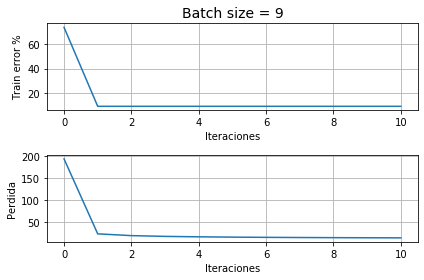

beta_hat= [-4.68180667  9.509749   -3.35442423  1.19280859  1.1928756   4.27419549
  0.78917096  2.27825098  1.09678643  2.04861855  1.91243402  2.21850039]
Error de clasificacion= 13.64 %


CPU times: user 14.7 s, sys: 1.95 s, total: 16.7 s
Wall time: 12.4 s


In [61]:
%%time

# Método de SGD
for batch_size in range(9,10):
    
    
    print("*========================================================================*")
    #print("Tamaño de minilote= ",batch_size)
    beta_hat, loss, error = SGD(x_train, y_train, max_iter=10**5, batch_size=batch_size)
    yhat = clasifica(x_test,beta_hat)
    titulo="Batch size = "+ str(batch_size)
    graf_loss_err(loss,error,titulo)
    print("beta_hat=", beta_hat)
    print("Error de clasificacion=",round(100*sum(abs(y_test-yhat))/len(yhat),2),"%")
    print("\n")

In [62]:
def n_batch(m):
    index=np.arange(0,m)
    np.random.shuffle(index)
    return index

In [63]:
import multiprocessing
import time
from dask.distributed import Client, progress
client = Client()

In [64]:
client

Client Scheduler: tcp://127.0.0.1:41343 Dashboard: http://127.0.0.1:34637/status,Cluster Workers: 4 Cores: 8 Memory: 8.21 GB


In [65]:
# paso 1. Dividir el dominio en partes iguales
cores = multiprocessing.cpu_count() # cpus disponibles
#n_subint = int(density_p/p) # número de puntos o nodos en cada core o cpu

In [66]:
def construye_indices(ids,m,cores):
    '''
    Argumentos:
    ----------
    * ids: Identificador del core dónde se está corriendo el task. 
    * m (array): Numero total de puntos de entrenamiento.
    * cores (int) : Número de cores o cpus disponibles
    
    Salidas:
    -------
    * (index_from, index_to): Rango de indices que se seleccionan del verctor de permutaciones
    '''
    
    tamano_int = int(m/cores) #tamaño de cada sub intervalo.
    index_from = ids*tamano_int #construyen los subintervalo
    index_to = index_from + tamano_int
    if ids==(cores-1): index_to=m
    return (index_from,index_to)


def evalua_gradiente(intervalo,perm,X,y,beta):
    """
    Función que evalúa el gradiente del riesgo empirico para cada conjunto de indices de permutaciones    
    Argumentos:
    ----------
    * intervalo: Intervalo de indices del vector perm a utilizar
    * perm: Vector de permutaciones 
    * X: Puntos de entrenamiento
    * y: Etiquetas de los puntos de entrenamiento
    * beta: Vector de parametros a optimizar
    
    Salidas:
    * Evaluacion del gradiente del riesgo empirico para un mini lote
    --------

    """   
    index=perm[intervalo[0]:intervalo[1]]
    x_lote = X[index,:]
    y_lote = y[index]
    gradiente=gradiente_riesgo_empirico(x_lote,y_lote,beta) 
    return gradiente


In [75]:
def SGD_paralelo(X,y,verbose_n=100,max_iter=10**5):
    
    '''
    
    
    
    '''

     # Se revisa que los parámetros de entrada sean congruentes con la funcionalidad
    m,p = X.shape
    if y.shape[0]!= m:
        sys.exit('Error:  El número de renglones de X debe ser igual al número de entradas del vector y.')


    # Inicializa
    m=X.shape[0]
    epsilon = 10**(-6)
    beta = np.random.normal(0,1,X.shape[1])    
    step_size=.01
    iteraciones = 0
    epoca=0
    
    # Primera iteracion
    perm=n_batch(m)
    #calcula los indices
    indices = client.map(construye_indices,range(cores),
                **{'m':m,'cores':cores})

    #evalua el gradiente en cada batch en paralelo
    grad_riesgo_empirico=client.map(evalua_gradiente,indices,
                **{'perm':perm,'X':X,'y':y,'beta':beta})

    results=client.gather(grad_riesgo_empirico)
    actualiza=sum(results)
    
    beta_new = beta - step_size * actualiza  
    #gradiente_riesgo_empirico(x_lote,y_lote,beta) 
    
    perdida=riesgo_empirico(X,y,beta)
    error=error_train(X,y,beta)
    
    # while ((np.linalg.norm(gradiente_f(X,y,beta_new)) > epsilon) & (iteraciones < max_iter)):
    # while abs(f(X,y,beta) - f(X,y,beta_new)) > epsilon:
    while iteraciones<max_iter:
        iteraciones +=1
        beta = beta_new
        perm=n_batch(m)
        #calcula los indices
        indices = client.map(construye_indices,range(cores),**{'m':m,'cores':cores})
        #evalua el gradiente en cada batch en paralelo
        grad_riesgo_empirico=client.map(evalua_gradiente,indices,
                     **{'perm':perm,'X':X,'y':y,'beta':beta})
        #gather results
        results=client.gather(grad_riesgo_empirico)
        actualiza=sum(results)
        
        beta_new = beta - step_size * actualiza
        end_time = time.time()
        
        if iteraciones%100==0:
            epoca+=1
            loss=riesgo_empirico(X,y,beta)
            perdida=np.append(perdida,loss)
            err=error_train(X,y,beta)
            error=np.append(error, error_train(x_test,y_test,beta_hat))
            print(f'loss:{loss:.4}, epoca:{epoca}, iter:{iteraciones}')
        #print("iteraciones3=",iteraciones)
    print("Nº DE INTERACIONES: ",iteraciones)
    return beta_new,perdida,error

*========================================================================*
loss:40.94, epoca:1, iter:100
loss:35.62, epoca:2, iter:200
loss:32.19, epoca:3, iter:300
loss:29.81, epoca:4, iter:400
loss:28.05, epoca:5, iter:500
loss:26.71, epoca:6, iter:600
loss:25.63, epoca:7, iter:700
loss:24.75, epoca:8, iter:800
loss:24.0, epoca:9, iter:900
loss:23.37, epoca:10, iter:1000
loss:22.81, epoca:11, iter:1100
loss:22.33, epoca:12, iter:1200
loss:21.89, epoca:13, iter:1300
loss:21.5, epoca:14, iter:1400
loss:21.15, epoca:15, iter:1500
loss:20.83, epoca:16, iter:1600
loss:20.54, epoca:17, iter:1700
loss:20.28, epoca:18, iter:1800
loss:20.03, epoca:19, iter:1900
loss:19.8, epoca:20, iter:2000
loss:19.58, epoca:21, iter:2100
loss:19.38, epoca:22, iter:2200
loss:19.2, epoca:23, iter:2300
loss:19.02, epoca:24, iter:2400
loss:18.86, epoca:25, iter:2500
loss:18.7, epoca:26, iter:2600
loss:18.55, epoca:27, iter:2700
loss:18.41, epoca:28, iter:2800
loss:18.28, epoca:29, iter:2900
loss:18.15, epoca:30

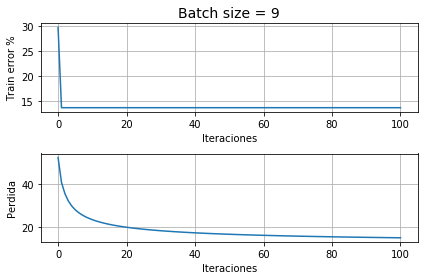

beta_hat= [-4.72682076  8.69637274 -3.26959518  0.39380814  1.08713375  3.96597329
  0.92662326  2.15827014  1.24870917  2.16223996  2.11991062  2.39540951]
Error de clasificacion= 13.64 %


CPU times: user 21min 52s, sys: 1min 36s, total: 23min 29s
Wall time: 22min 9s


In [76]:
%%time

# Método de SGD
for batch_size in range(9,10):
    
    
    print("*========================================================================*")
    #print("Tamaño de minilote= ",batch_size)
    beta_hat, loss, error = SGD_paralelo(x_train, y_train, max_iter=10**4)
    yhat = clasifica(x_test,beta_hat)
    titulo="Batch size = "+ str(batch_size)
    graf_loss_err(loss,error,titulo)
    print("beta_hat=", beta_hat)
    print("Error de clasificacion=",round(100*sum(abs(y_test-yhat))/len(yhat),2),"%")
    print("\n")